In [ ]:
import numpy as np
import json
from math import*
import sys

def hits(M, epsilon=1e-5):
    m, n = np.shape(M)
    A = np.ones((n, 1), dtype=np.float64)
    H = np.ones((m, 1), dtype=np.float64)
    authM = np.matmul(M.T, M)
    hubM = np.matmul(M, M.T)
    # e,ev=np.linalg.eig(hubM)
    # m=e.argsort()[-1] # index of maximum eigenvalue
    # H=np.array(ev[:,m]).flatten()
    # e,ev=np.linalg.eig(authM)
    # m=e.argsort()[-1] # index of maximum eigenvalue
    # A=np.array(ev[:,m]).flatten()
    # print(type(A))
    epsilon_matrix_a = epsilon * np.ones((n, 1))
    epsilon_matrix_h = epsilon * np.ones((m, 1))
    authM = np.matmul(M.T, M)
    hubM = np.matmul(M, M.T)
    A = A / np.sum(A, axis=None)
    H = H / np.sum(H, axis=None)
    for i in range(n):
        A_old = A
        H_old = H
        A = np.matmul(authM, A)
        H = np.matmul(hubM, H)
        A = A / (np.max(A, axis=None))
        H = H / (np.max(H, axis=None))
        if (((abs(H - H_old)) < epsilon_matrix_h).all()) and (((abs(A - A_old)) < epsilon_matrix_a).all()):
			break
    A = A / (np.sum(A, axis=None))
    H = H / (np.sum(H, axis=None))
    for i in range(n):
        if(A[i,0]<0.0001): A[i,0]=0
    for j in range(m):
        if(H[j,0]<0.0001): H[j,0]=0
    return A,H

def distinctMatrices(data):
    users = {} #size = m
    tweets = {} #size = n
    ucount = 0
    tcount = 0
    for i in range(len(data["json"])):
        #User-id : index matrix
        if(data["json"][i]["user_id"] not in users.keys()):
            #users[ucount] = data["json"][i]["user_id"]
            users[data["json"][i]["user_id"]] = ucount
            ucount = ucount+1
        #Tweet-id : index matrix
        if(data["json"][i]["id"] not in tweets.keys()):
            # tweets[tcount] = []
            # tweets[tcount].append(data["json"][i]["id"])
            # tweets[tcount].append(data["json"][i]["text"])
            tweets[data["json"][i]["id"]] = tcount
            tcount = tcount+1
    return users, tweets

def authority_hub_scores():  
    with open('final_output.json') as f:
        data = json.load(f)
    users, tweets = distinctMatrices(data)
    m = len(users)
    n = len(tweets)
    #User-post matrix
    matrix = np.zeros((m, n), dtype=np.uint32)

    f.close()
    with open('final_output.json') as f:
        data = json.load(f)

    for i in range(len(data["json"])):
        uid = data["json"][i]["user_id"]
        id = data["json"][i]["id"]
        if(matrix[users[uid], tweets[id]]<=data["json"][i]["retweet_count"]):
            matrix[users[uid], tweets[id]] = data["json"][i]["retweet_count"]+1
    
    authScore, hubScore = hits(matrix)
    f.close()
    return authScore, hubScore

def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def extractTweetIndexMatrix(tindex):
    with open('final_output.json') as f:
        data = json.load(f)
    tweets = {} #size = n
    tcount = 0
    for i in range(len(data["json"])):
        if(tindex[data["json"][i]["id"]]==tcount):
            tweets[tcount] = []
            tweets[tcount].append(data["json"][i]["id"])
            tweets[tcount].append(data["json"][i]["text"])
            tcount = tcount+1
    f.close()
    return tweets

def minDistance(tweets, authScore):
    minDist = np.zeros((len(tweets),1))
    print(len(tweets), len(authScore))
    for i in range(len(tweets)):
        minSim = sys.maxint
        for j in range(len(authScore)):
            if(authScore[j]>authScore[i]):
                sim = jaccard_similarity(tweets[i][1], tweets[j][1])
                if(sim < minSim): minSim = sim
        minDist[i,0] = minSim
    for i in range(len(authScore)):
        if(authScore[i]==np.max(authScore, axis=0)):
            minDist[i,0] = np.max(minDist)
    return minDist

with open('final_output.json') as f:
    data = json.load(f)
userIndex, tweetsIndex = distinctMatrices(data)
f.close()
authScore, hubScore = authority_hub_scores()
for i in authScore:
    if(i>0.0001): print i
for j in hubScore:
    if(j>0.0001): print j
tweets = extractTweetIndexMatrix(tweetsIndex)
minDist = minDistance(tweets, authScore)
for i in minDist:
    if(i>0): print i
#plotting code


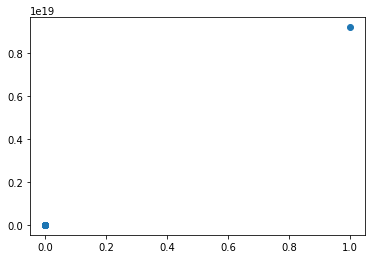

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(np.concatenate((authScore, minDist)))
plt.plot(authScore, minDist, 'o')
plt.show()